In [1]:
import copy
import matplotlib.pyplot as plt
import random
import networkx as nx
from matplotlib import colors
from networkx.drawing.nx_agraph import graphviz_layout


In [2]:
def columns(board):
    return len(board[0])

def rows(board):
    return len(board)   

def moves_available(board) -> list:
    return [c for c in range(columns(board)) if board[0][c] == '-']

def play(board, player:str, column:int):
        
    column_values = [row[column] for row in board]
    row = max([i for i,v in enumerate(column_values) if v=='-']) # the row to which the chip will fall
    new_board = copy.deepcopy(board)
    new_board[row][column] = player
    return new_board


def fourInARow(row, col, board):
    '''
    '''
    if board[row][col] == '-':
        return None
    
    # vertical down: 
    if row < len(board)-3:
        if (board[row][col] == board[row+1][col] == board[row+2][col] == board[row+3][col]):
            return board[row][col]
    
    # horizontal right:
    if col < len(board[0])-3:
        if (board[row][col] == board[row][col+1] == board[row][col+2] == board[row][col+3]):
            return board[row][col]

    # right diag: 
    if (row < len(board)-3) & (col < len(board[0])-3):
        if (board[row][col] == board[row+1][col+1] == board[row+2][col+2] == board[row+3][col+3]):
            return board[row][col]

    # left diag: 
    if (row < len(board)-3) & (col > 2):
        if (board[row][col] == board[row+1][col-1] == board[row+2][col-2] == board[row+3][col-3]):
            return board[row][col]
    return None


def checkWin(board):
    '''
    '''
    for row in range(rows(board)):
        for col in range(columns(board)):
            check_win = fourInARow(row, col, board)
            if check_win: 
                return check_win

    return None


def board2string(board):
    board_string = []
    for row in board:
        board_string.append(''.join([c for c in row]))
    return '\n'.join(board_string)

def plotBoard(board):
    mapping = {'-': 0, 'Y': 1, 'R': 2}
    boardColors = []
    for row in board:
        boardColors.append([mapping[v] for v in row])

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['gray', 'yellow', 'red'])
    bounds=[0,0.5,1.5,2]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots()
    c = ax.pcolor(boardColors, edgecolors='k', linewidths=4, cmap=cmap, norm=norm)
    ax.invert_yaxis()
    #ax.set_axis_off()
    ax.set_aspect('equal')
    return ax

Winner: Y


[]

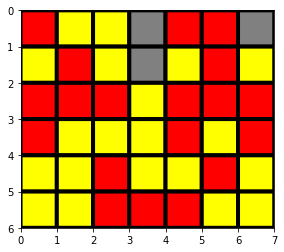

In [18]:
board = [
    ['-', '-', '-', '-', '-', '-', '-'],
    ['-', '-', '-', '-', '-', '-', '-'],
    ['-', '-', '-', '-', '-', '-', '-'],
    ['-', '-', '-', '-', '-', '-', '-'],
    ['-', '-', '-', '-', '-', '-', '-'],
    ['-', '-', '-', '-', '-', '-', '-']
]


player = 'Y'
winner = None
while not winner:
    moves = moves_available(board)
    move = random.choice(moves)
    #print(f'Player: {player}, Move: {move}')

    board = play(board=board, player=player, column=move)
    winner = checkWin(board)

    # switch players
    player = {'Y': 'R', 'R': 'Y'}.get(player) 

print(f'Winner: {winner}')
ax = plotBoard(board)
ax.plot()

# Graph helper functions

In [19]:
def draw_graph(G, fig_size=(5, 5), node_label=None, edge_label=None):
    """A utility method to draw a given graph"""
    f, ax = plt.subplots(figsize=fig_size)
    G.graph.setdefault('graph', {})['rankdir'] = 'LR'
    # color nodes based on winner
    node_color = []
    node_size = 50
    pos = graphviz_layout(G, prog='dot')
    if node_label:
        nx.draw_networkx(G, pos=pos, labels=nx.get_node_attributes(
            G, node_label), node_color=node_color, node_size=node_size)
    else:
        nx.draw_networkx(G, pos=pos, with_labels=False,
                         node_color=node_color, node_size=node_size)
    if edge_label:
        nx.draw_networkx_edge_labels(
            G, pos=pos, edge_labels=nx.get_edge_attributes(G, edge_label))
    plt.show()
    return

# Graph compostion:

- Edges represtent moves. A move is an int between [0, 6] representing the column played.
- Nodes represent the board state following the sequence of moves played by the incoming edges.

# Testing recursion for gameplay

In [24]:
def search(board, max_depth=3):  # -> DiGraph
    """
    Run game simulations from current game state to a maximum number
    of moves ahead (max_depth)
    Return the graph of possible moves and outcomes
    Assume current player is player to be maximized
    """

    depth = 0
    n = 0  # node label which also serves as a node counter

    G = nx.DiGraph()
    winner = checkWin(board)
    G.add_node(0, winner=winner, board=board, label=board2string(board), n=n)
    # First branch in look ahead
    child_nodes = []

    for move in moves_available(board):
        # Do move
        new_board = play(board, player='Y', column=move)
        winner = checkWin(new_board)
        # Add move node to graph
        n = n+1
        G.add_node(n, winner=winner, board=new_board, label=board2string(new_board), n=n)
        G.add_edge(0, n, move=move)
        
        if winner:
            ##
            print(f'Winner: {winner}, {n}')
            continue
        child_nodes.append(n)

    depth += 1
    # Subsequent branches
    while depth < max_depth:
        child_node_subtree = child_nodes[:]
        child_nodes = []
        for child in child_node_subtree:
            # Get parent state
            parent_board = G.nodes(data=True)[child]['board']
            for move in moves_available(parent_board):
                # Do move
                new_board = play(parent_board, player='Y', column=move)
                winner = checkWin(new_board)
                # Add move node to graph
                n = n+1
                G.add_node(n, winner=winner, board=new_board, label=board2string(new_board), n=n)
                G.add_edge(child, n, move=move)
                if winner:
                    ##
                    print(f'Winner: {winner}, {n}')
                    continue
                child_nodes.append(n)
        depth = depth+1
    return G

# Connect4 Graph Creation

<AxesSubplot:>

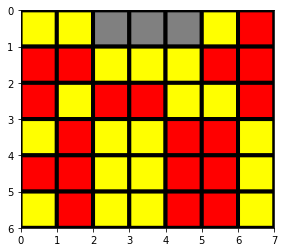

In [25]:
board=[
    ['Y','Y','-','-','-','Y','R'],
    ['R','R','Y','Y','Y','R','R'],
    ['R','Y','R','R','Y','Y','R'], 
    ['Y','R','Y','Y','R','R','Y'],
    ['R','R','Y','Y','R','R','Y'],
    ['Y','R','Y','Y','R','R','Y']
]
plotBoard(board)

In [29]:
G = search(board=board, max_depth=2)

Winner: Y, 2
Winner: Y, 4
Winner: Y, 7


In [30]:
# plotBoard(G.nodes[0]['board'])
# plotBoard(G.nodes[3]['board'])

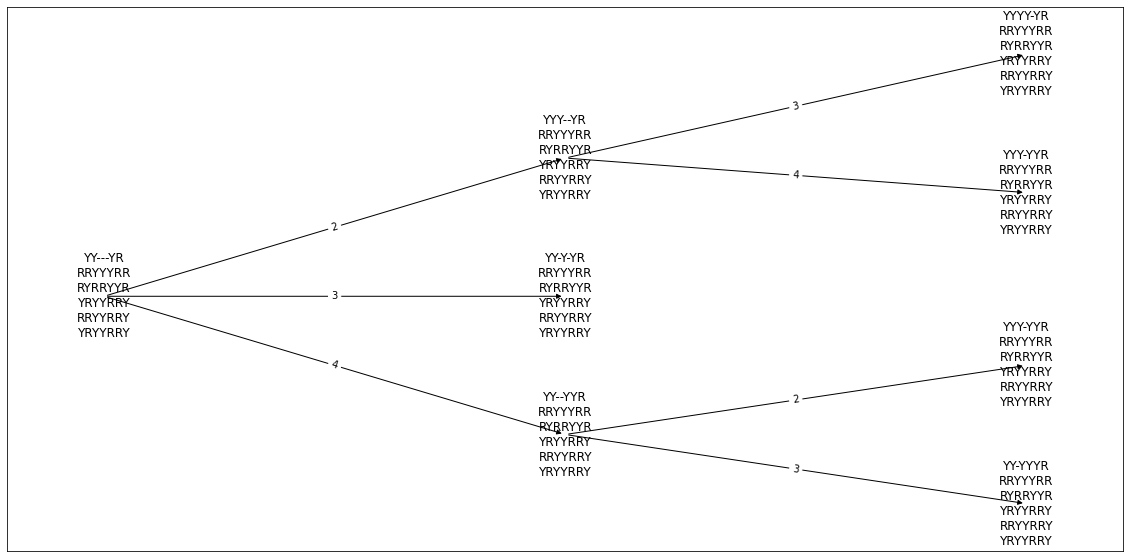

In [31]:
draw_graph(G, fig_size=(20,10), node_label='label', edge_label='move')

[2, 3, 4]
[2, 4]


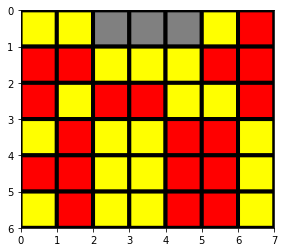

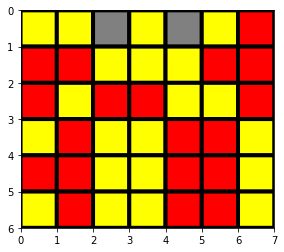

In [32]:
n=0
plotBoard(G.nodes[n]['board'])
print(moves_available(G.nodes[n]['board']))

n=2
plotBoard(G.nodes[n]['board'])
print(moves_available(G.nodes[n]['board']))